<a href="https://colab.research.google.com/github/nikhildhavale/pythonLearning/blob/main/adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded Titanic train.csv — shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C



Columns used for modeling:
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'CabinDeck', 'TicketPrefix']

=== BASELINE MODEL RESULTS ===
              precision    recall  f1-score   support

           0     0.8407    0.8636    0.8520       110
           1     0.7727    0.7391    0.7556        69

    accuracy                         0.8156       179
   macro avg     0.8067    0.8014    0.8038       179
weighted avg     0.8145    0.8156    0.8148       179

Accuracy: 0.8156
ROC AUC: 0.8404


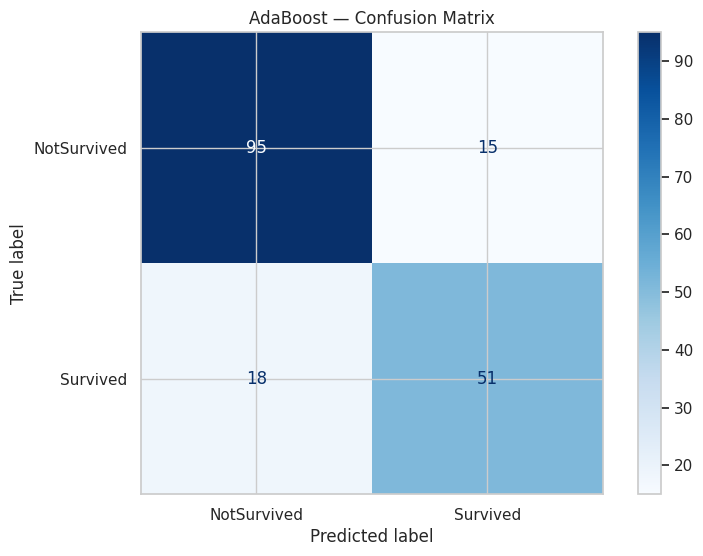


Top 15 Feature Importances:


,feature,importance
1,Fare,0.341101
0,Age,0.207899
14,Title_Mr,0.094194
4,FamilySize,0.046317
6,Pclass,0.045729
48,TicketPrefix_SWPP,0.027251
8,Sex_male,0.023944
20,CabinDeck_D,0.019485
21,CabinDeck_E,0.018255
42,TicketPrefix_SOPP,0.016498


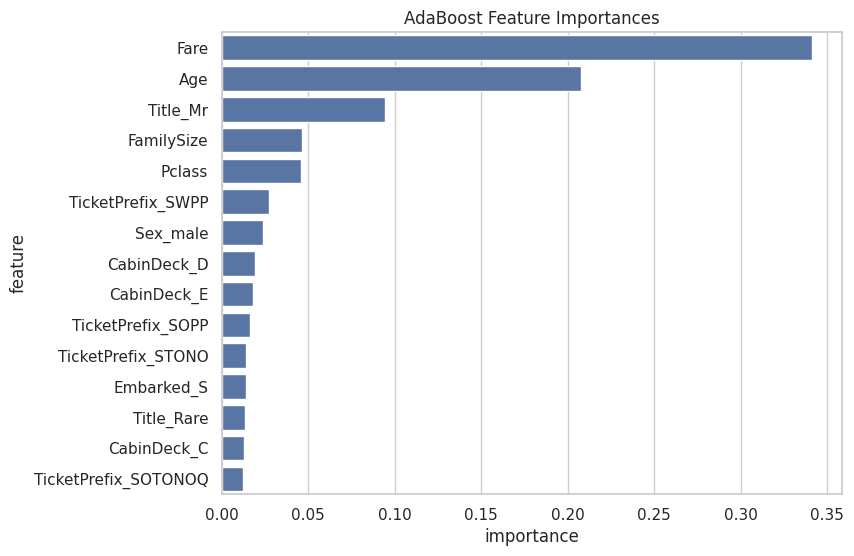

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] END ..clf__estimator__max_depth=1, clf__n_estimators=50; total time=   0.2s
[CV] END ..clf__estimator__max_depth=1, clf__n_estimators=50; total time=   0.1s
[CV] END ..clf__estimator__max_depth=1, clf__n_estimators=50; total time=   0.1s
[CV] END ..clf__estimator__max_depth=1, clf__n_estimators=50; total time=   0.1s
[CV] END .clf__estimator__max_depth=1, clf__n_estimators=100; total time=   0.3s
[CV] END .clf__estimator__max_depth=1, clf__n_estimators=100; total time=   0.4s
[CV] END .clf__estimator__max_depth=1, clf__n_estimators=100; total time=   0.4s
[CV] END .clf__estimator__max_depth=1, clf__n_estimators=100; total time=   0.4s
[CV] END ..clf__estimator__max_depth=2, clf__n_estimators=50; total time=   0.2s
[CV] END ..clf__estimator__max_depth=2, clf__n_estimators=50; total time=   0.2s
[CV] END ..clf__estimator__max_depth=2, clf__n_estimators=50; total time=   0.2s
[CV] END ..clf__estimator__max_depth=2, clf__n_es

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,CabinDeck,TicketPrefix
565,3,male,24.0,2,0,24.15,S,Mr,3,0,Unknown,A4


Predicted Survived: 0   Probability: 0.3285


In [2]:
# TITANIC: EDA -> Preprocessing -> AdaBoostClassifier (UPDATED for scikit-learn >= 1.2)
# Includes: EDA, Missing-value handling, Feature Engineering, Pipeline, AdaBoost, GridSearch, Feature importance.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)
RND = 42
warnings.filterwarnings("ignore")

# -------------------------
# LOAD DATA
# -------------------------
df = pd.read_csv("train.csv")
print("Loaded Titanic train.csv — shape:", df.shape)
display(df.head(10))

# -------------------------
# FEATURE ENGINEERING
# -------------------------

# Extract Title
def extract_title(name):
    if pd.isna(name):
        return "Unknown"
    if "," in name and "." in name:
        return name.split(",")[1].split(".")[0].strip()
    return "Unknown"

df["Title"] = df["Name"].apply(extract_title)

# Rare title grouping
title_counts = df["Title"].value_counts()
rare_titles = title_counts[title_counts < 10].index.tolist()
df["Title"] = df["Title"].replace(rare_titles, "Rare")

# Family features
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

# Cabin deck extraction
df["CabinDeck"] = df["Cabin"].fillna("U").str[0]
df["CabinDeck"] = df["CabinDeck"].replace("U", "Unknown")

# Ticket prefix
def ticket_prefix(ticket):
    if pd.isna(ticket):
        return "None"
    t = ticket.replace(".", "").replace("/", "").strip().split()
    if len(t) > 1:
        return t[0].upper()
    return "None"

df["TicketPrefix"] = df["Ticket"].astype(str).apply(ticket_prefix)

# Drop unused columns
df_model = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
print("\nColumns used for modeling:")
print(df_model.columns.tolist())

# -------------------------
# PREPROCESSING PIPELINE
# -------------------------
categorical_cols = ["Sex", "Embarked", "Title", "CabinDeck", "TicketPrefix"]
numeric_cols     = ["Age", "Fare", "SibSp", "Parch", "FamilySize", "IsAlone", "Pclass"]

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", Pipeline([("impute", num_imputer)]), numeric_cols),
    ("cat", Pipeline([("impute", cat_imputer), ("ohe", ohe)]), categorical_cols),
])

estimator_tree = DecisionTreeClassifier(max_depth=3, random_state=RND)

clf_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", AdaBoostClassifier(estimator=estimator_tree, n_estimators=50, random_state=RND))
])

# -------------------------
# TRAIN/TEST SPLIT
# -------------------------
X = df_model.drop("Survived", axis=1)
y = df_model["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)

# -------------------------
# TRAIN BASELINE MODEL
# -------------------------
clf_pipeline.fit(X_train, y_train)

y_pred  = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== BASELINE MODEL RESULTS ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["NotSurvived", "Survived"]).plot(cmap="Blues")
plt.title("AdaBoost — Confusion Matrix")
plt.show()

# -------------------------
# FEATURE IMPORTANCE
# -------------------------
ohe_features = clf_pipeline.named_steps["preproc"]\
    .named_transformers_["cat"].named_steps["ohe"]\
    .get_feature_names_out(categorical_cols)

feature_names = numeric_cols + list(ohe_features)
importances = clf_pipeline.named_steps["clf"].feature_importances_

feat_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_df = feat_df.sort_values("importance", ascending=False)

print("\nTop 15 Feature Importances:")
display(feat_df.head(15))

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_df.head(15))
plt.title("AdaBoost Feature Importances")
plt.show()

# -------------------------
# GRID SEARCH (UPDATED PARAM NAMES)
# -------------------------
param_grid = {
    "clf__n_estimators": [50, 100],
    "clf__estimator__max_depth": [1, 2, 3]  # UPDATED NAME
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RND)

grid = GridSearchCV(
    clf_pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid.fit(X_train, y_train)

print("\nBest GridSearch Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# -------------------------
# FINAL EVALUATION
# -------------------------
best_model = grid.best_estimator_

y_pred_best  = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n=== FINAL MODEL RESULTS ===")
print(classification_report(y_test, y_pred_best, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_best):.4f}")

# -------------------------
# SAVE MODEL
# -------------------------
joblib.dump(best_model, "titanic_adaboost_pipeline.joblib")
print("\nModel saved → titanic_adaboost_pipeline.joblib")

# -------------------------
# SINGLE SAMPLE PREDICTION
# -------------------------
sample = X_test.iloc[[0]]
print("\nSample input:")
display(sample)

pred = best_model.predict(sample)[0]
proba = best_model.predict_proba(sample)[0][1]

print(f"Predicted Survived: {pred}   Probability: {proba:.4f}")